In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import torch
import time
import pytorch_lightning as pl
from pytorch_lightning import loggers
import config
from utils.Visual import drawPlot

# Experiments

Here we showcase 3 types of experiments:

* **Hyperparameter optimization** for training of a model (*using Optuna*) **[not ready yet]**

* **Adversarial Training** of a model for different hyperparameters

* Evaluation of **Adversarial Attacks**


Preconditions:

* you need a ***PL-Module*** that specifies your model class and dataset!

## Define model(s)

In [3]:
from datasets.datasethandler import DatasetHandler
datasetHandler = DatasetHandler()

models = {}

In [4]:
from classification.models.DeepRecursiveCNN import DeepRecursiveCNNPLModule


hparams = {
    "batch_size": 5,
    "learning_rate": 3e-4,
    "weight_decay": 0.001,
    "lr_decay": 0.95
}


model = DeepRecursiveCNNPLModule(hparams)
datasetHandler.load_datasets(model)
models[model.__class__.__name__] = model

Load: /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_resampled/training.p
Load: /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_resampled/validation.p


In [5]:
from classification.models.SpectrogramCNN import SpectrogramCNNPLModule

hparams = {
    "batch_size": 64,
    "learning_rate": 3e-4,
    "weight_decay": 0.001,
    "lr_decay": 0.95
}

model = SpectrogramCNNPLModule(hparams)
datasetHandler.load_datasets(model)
models[model.__class__.__name__] = model

In [11]:
from classification.models.M5 import M5, M5PLModule

hparams = {
    "batch_size": 64,
    "learning_rate": 3e-4,
    "weight_decay": 0.001,
    "lr_decay": 0.95
}

model = M5PLModule(hparams)
datasetHandler.load_datasets(model)

models[model.__class__.__name__] = model

In [ ]:
model = models['SpectrogramCNNPLModule'] # select model

# Training of a Model

* define your hyperparameters in `hparams`
* create your instance of `PLModule`
* define a trainer (e.g., define max epochs, ...)
* fit your model!

In [70]:
trainer = pl.Trainer(
    max_epochs = 1,
   # logger = loggers.TensorBoardLogger(config.LOG_DIR, name="M5"),
    gpus = 1 if torch.cuda.is_available() else None,
    log_gpu_memory = 'all'
)

trainer.fit(model)
model.save("./" + str(int(time.time())) + ".p")

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/students/summer-term-2020/project-4/yan/.conda/envs/cnn_project/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

   | Name        | Type           | Params
-------------------------------------------
0  | model       | SpectrogramCNN | 338 K 
1  | model.bn0   | BatchNorm2d    | 2     
2  | model.conv1 | Conv2d         | 505   
3  | model.bn1   | BatchNorm2d    | 10    
4  | model.conv2 | Conv2d         | 2 K   
5  | model.bn2   | BatchNorm2d    | 10    
6  | model.conv3 | Conv2d         | 20 K  
7  | model.bn3   | BatchNorm2d    | 20    
8  | model.conv4 | Conv2d         | 60 K  
9  | model.bn4   | BatchNorm2d    | 

Val-Acc=0.03793716656787196


/nfs/students/summer-term-2020/project-4/yan/.conda/envs/cnn_project/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7729697688203913

Saved model to "./1592171545.p"


/nfs/students/summer-term-2020/project-4/yan/.conda/envs/cnn_project/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: The metric you returned None must be a Torch.Tensor instance, checkpoint not saved HINT: what is the value of val_loss in validation_end()?
  warnings.warn(*args, **kwargs)
/nfs/students/summer-term-2020/project-4/yan/.conda/envs/cnn_project/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)


# II: Adversarial Training

* same as normal training, but call **`model.setAttack`** 


Today:

* source this out as another experiment class, e.g. AdversarialTrainingExperiment
* pass folder name to initialization
* save: hparams, attack_args, attack_class, train_params
* 

In [9]:
from attacks.pgd import ProjectedGradientDescent 

attack_args = [{"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 1e-4, "u": 0.1 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 1e-4, "u": 0.2 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 1e-4, "u": 0.5 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 0.1, "u": 0.2 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 0.1, "u": 0.5 } },
                {"norm": "inf", "epsilon": 0.1 },
                {"norm": "inf", "epsilon": 0.2 },
                {"norm": "inf", "epsilon": 0.5 },

                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 1, "u": 5000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 1, "u": 10000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 1, "u": 20000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 5000, "u": 10000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 5000, "u": 20000 } },
                {"norm": "1", "epsilon": 5000 },
                {"norm": "1", "epsilon": 10000 },
                {"norm": "1", "epsilon": 20000 },
              
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 0.001, "u": 20 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 0.001, "u": 50 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 0.001, "u": 100 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 10, "u": 50 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 20, "u": 100 } },
                {"norm": "2", "epsilon": 20 },
                {"norm": "2", "epsilon": 50 },
                {"norm": "2", "epsilon": 100 }]
              

prefix = str(int(time.time()))


def adv_train(attack_args):
    for i in range(len(attack_args)):
        model = SpectrogramCNNPLModule(hparams)
        datasetHandler.load_datasets(model)
        model.setAttack(ProjectedGradientDescent, attack_args[i])
        
        prefix = "trial#{}_l{}".format(i, attack_args[i]["norm"])

        trainer = pl.Trainer(
            max_epochs=300,
            #logger= loggers.TensorBoardLogger(config.LOG_DIR, name="M5"),
            gpus=1 if torch.cuda.is_available() else None,
            log_gpu_memory='all'
        )
        trainer.fit(model)
        model.save("./adv_training_results/" + prefix + "_adv.p")

adv_train([attack_args[0]])

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/students/summer-term-2020/project-4/yan/.conda/envs/cnn_project/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

   | Name        | Type           | Params
-------------------------------------------
0  | model       | SpectrogramCNN | 338 K 
1  | model.bn0   | BatchNorm2d    | 2     
2  | model.conv1 | Conv2d         | 505   
3  | model.bn1   | BatchNorm2d    | 10    
4  | model.conv2 | Conv2d         | 2 K   
5  | model.bn2   | BatchNorm2d    | 10    
6  | model.conv3 | Conv2d         | 20 K  
7  | model.bn3   | BatchNorm2d    | 20    
8  | model.conv4 | Conv2d         | 60 K  
9  | model.bn4   | BatchNorm2d    | 

Val-Acc=0.03912270302311796


/nfs/students/summer-term-2020/project-4/yan/.conda/envs/cnn_project/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.8168346176644932


/nfs/students/summer-term-2020/project-4/yan/.conda/envs/cnn_project/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: The metric you returned None must be a Torch.Tensor instance, checkpoint not saved HINT: what is the value of val_loss in validation_end()?
  warnings.warn(*args, **kwargs)
/nfs/students/summer-term-2020/project-4/yan/.conda/envs/cnn_project/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)
Detected KeyboardInterrupt, attempting graceful shutdown...


FileNotFoundError: [Errno 2] No such file or directory: './adv_training_results/trial#0_linf_adv.p'

# III: Robustness Evaluation

Running a single attack:

In [10]:
from attacks.pgd import ProjectedGradientDescent
attack = ProjectedGradientDescent(model.model, model.train_dataloader(), {"norm":"inf", "epsilon": 10.}, early_stopping=-1, device='cuda', save_samples=False)
attack.attack()
attack.report( )

KeyboardInterrupt: 

### Documentation
* you define an experiment: an object of class `utils.RobustnessExperiment`.
    * pass a title & description for the experiment (optional)
    * pass different attacks + a list of configs, e.g.    
    
```python

exp_config = [           
              {
               "attack_fn": fast_gradient_attack, 
               "attack_arg": {"norm":["inf"], "epsilon": [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]},
               "meta": {"key_result":"acc", "key_config":"epsilon", "title":"FGSM"}
              }
            ]
```

* all values in `attack_arg` must be in brackets. The attack will the be run for all of the values in each of the lists

* you then can **run** the experiment by passing a **model**
* the following will happen:
    * initializing of the experiment creates a folder in the dir specified in config, named ID_title. Also a pickle file will be saved to the directory.
    * if you run an attack:
        * a sub-folder in that directory will be created for the model.
        * all attacks will be ran
        * for every attack, a plot will be created
        * one json (i.e. one for each model) will be saved to the directory
        * also some samples are stored for each attack.
        
        
Workflow:

* prepare experiment config and use it to initalize experiment
* then add as many models you like
* best: run this not in notebook but as slurm job

Created Dir '/nfs/students/summer-term-2020/project-4/experiments/0022_TEST'
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/27 [00:00<?, ?it/s]



Running experiment on model 1592000682.p
Created Dir '/nfs/students/summer-term-2020/project-4/experiments/0022_TEST/1592000682.p'

Perform Attack #1/3: FGSM


100%|██████████| 12/12 [00:47<00:00,  3.99s/it]


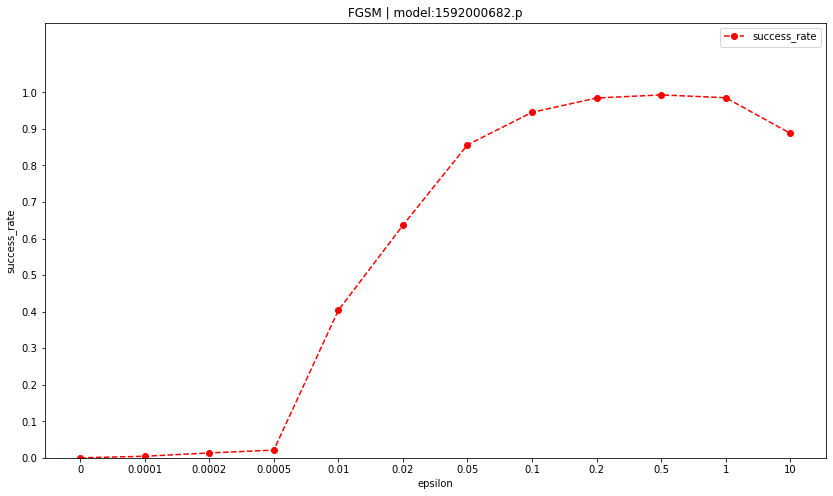

  0%|          | 0/27 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/experiments/0022_TEST/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 11/11 [00:44<00:00,  4.02s/it]


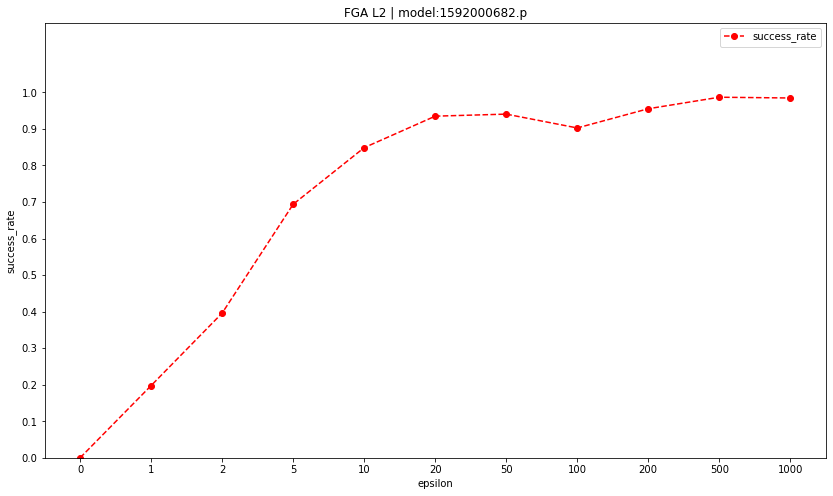

  0%|          | 0/27 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/experiments/0022_TEST/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 10/10 [00:40<00:00,  4.03s/it]


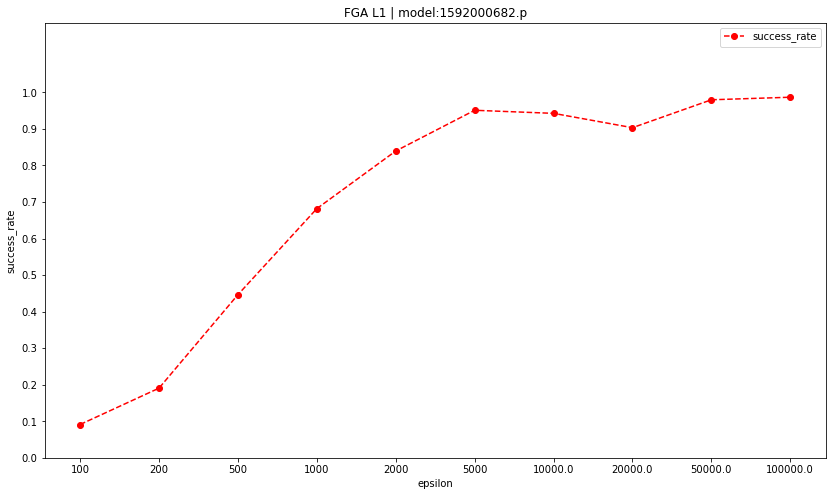

Backup created at "/nfs/students/summer-term-2020/project-4/experiments/0022_TEST/backup.pickle"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/27 [00:00<?, ?it/s]



Running experiment on model 1592000852_adv.p
Created Dir '/nfs/students/summer-term-2020/project-4/experiments/0022_TEST/1592000852_adv.p'

Perform Attack #1/3: FGSM


100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


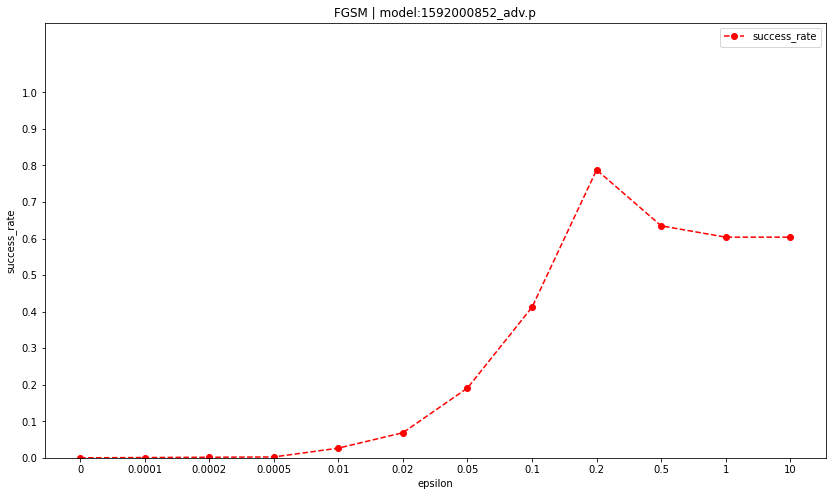

  0%|          | 0/27 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/experiments/0022_TEST/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 11/11 [00:41<00:00,  3.78s/it]


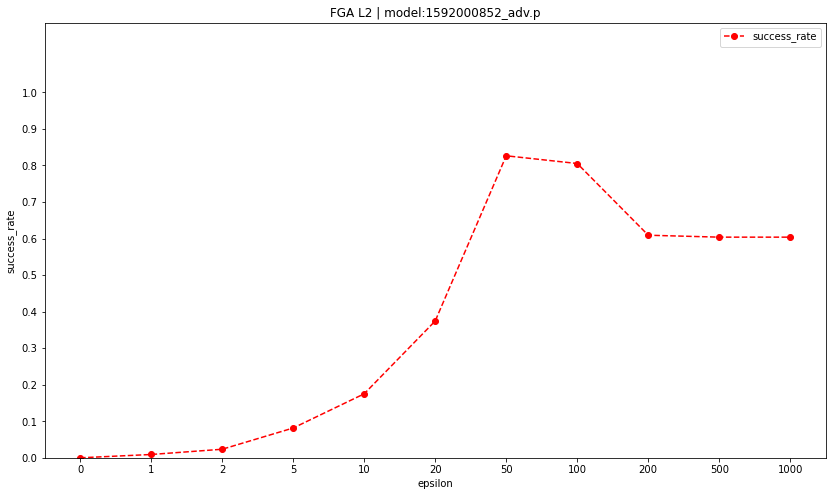

  0%|          | 0/27 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/experiments/0022_TEST/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


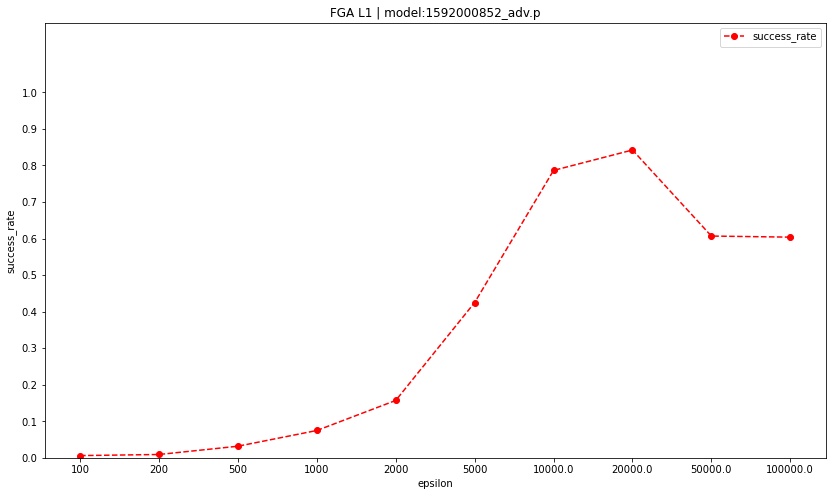

Backup created at "/nfs/students/summer-term-2020/project-4/experiments/0022_TEST/backup.pickle"


In [11]:
from utils.RobustnessExperiment import RobustnessExperiment
from attacks.FGA_Batch import fast_gradient_attack
from attacks.pgd import ProjectedGradientDescent

exp_config = [{
              "attack_fn": ProjectedGradientDescent, 
              "attack_arg": {"norm":["inf"], "epsilon": [0, 0.0001, 0.0002, 0.0005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 10]},
              "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGSM"}
             },
            {
            "attack_fn": ProjectedGradientDescent, 
            "attack_arg": {"norm":["2"], "epsilon": [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]},
            "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGA L2"}
            },
            {
            "attack_fn": ProjectedGradientDescent, 
            "attack_arg": {"norm":["1"], "epsilon": [100, 200, 500, 1000, 2000, 5000, 1e4, 2e4, 5e4, 1e5]},
            "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGA L1"}
            }]

#experiment = RobustnessExperiment(exp_config, title="TEST")
#experiment = load_experiment(exp_folder = "0016_TEST")

experiment.run("./1592000682.p", M5PLModule) #20 epochs normal training with hparams above
experiment.run("./1592000852_adv.p", M5PLModule) #5 epochs adv training with hparams above
#experiment.run("./1592007017_adv.p", M5PLModule) #20 epochs '' L2, 15 fixed
#experiment.run("./1592008146_adv.p", M5PLModule) #50 epochs '' 
#experiment.run("./1592010563_adv.p", M5PLModule) # 50 epochs, L1, 5000 fixed

# Which model performs best?

In [19]:
experiment.show_best_models(metric = "success_rate", best_n=1)


Attack = FGSM:
[(3.332830188679245, '1592000852_adv.p')]

Attack = FGA L2:
[(4.111698113207547, '1592000852_adv.p')]

Attack = FGA L1:
[(3.5426415094339623, '1592000852_adv.p')]


In [15]:
experiment.show_evaluated_models()

['1592000682.p', '1592000852_adv.p']

## Compare
* compare different models how robust they are! (i.e., success_rate vs. epsilon curves)

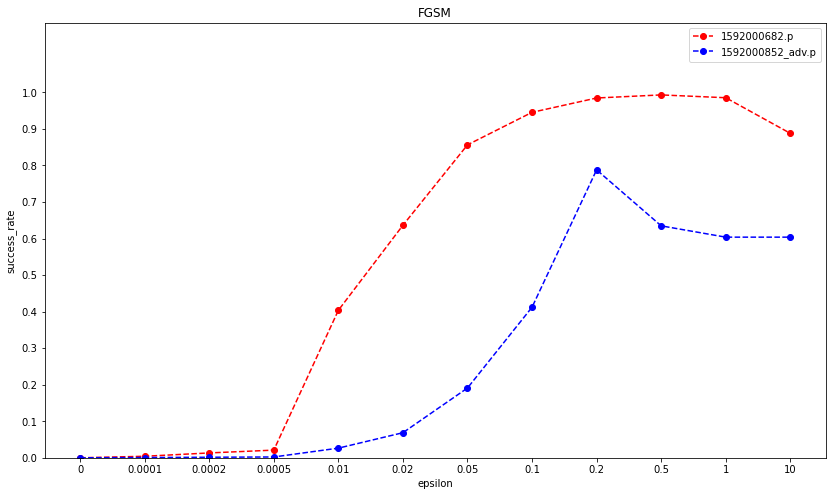

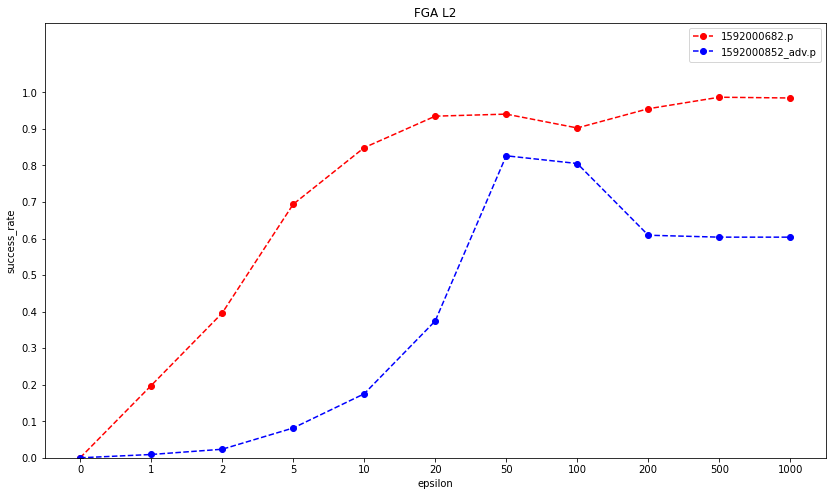

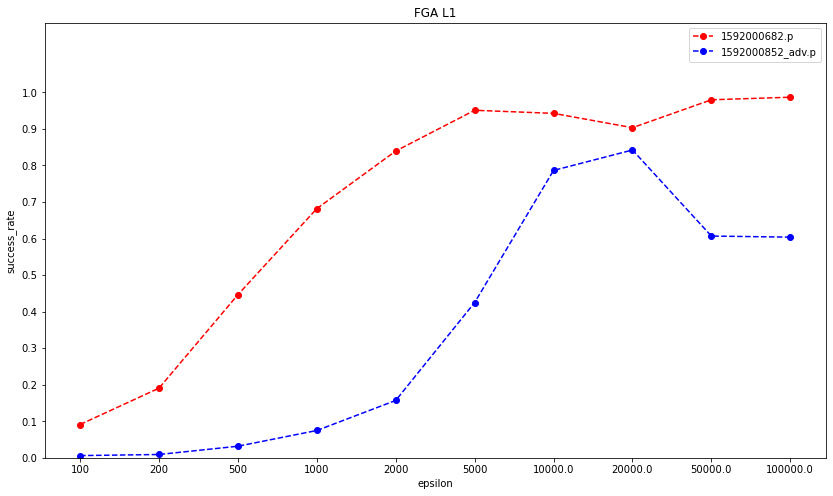

In [20]:
experiment.compare(config_key = "epsilon", results_key = "success_rate", models=['1592000682.p', '1592000852_adv.p'])